In [1]:
# This code achieves a performance of around 96.60%. However, it is not
# directly comparable to the results reported by the TGN paper since a
# slightly different evaluation setup is used here.
# In particular, predictions in the same batch are made in parallel, i.e.
# predictions for interactions later in the batch have no access to any
# information whatsoever about previous interactions in the same batch.
# On the contrary, when sampling node neighborhoods for interactions later in
# the batch, the TGN paper code has access to previous interactions in the
# batch.
# While both approaches are correct, together with the authors of the paper we
# decided to present this version here as it is more realsitic and a better
# test bed for future methods.

import sys
sys.path.insert(0, '/app')

import torch
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.nn import Linear

from torch_geometric.loader import TemporalDataLoader
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.nn.models.tgn import (
    IdentityMessage,
    LastAggregator,
    LastNeighborLoader,
)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from scenario_identification.utils.early_stopper import EarlyStopper


import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from torch_geometric.data import TemporalData,InMemoryDataset
import argparse
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from scenario_identification.utils.path_helper import get_dataset_path, get_in_memory_dataset_path


import scenario_identification.utils.path_helper as path_helper
import scenario_identification.utils.data_loader as loader

from collections import Counter
import matplotlib.pyplot as plt
from dotenv import load_dotenv


BUILD_DEVICE='local'

load_dotenv()

BUILD_DEVICE = os.getenv("BUILD_DEVICE")
print(f"Build Device: {BUILD_DEVICE}")





from scenario_identification.utils.path_helper import DatasetType


DATASET_TYPE = DatasetType.NODE_CLASSIFICATION_SITUATION_LABELS.value

Build Device: local


In [2]:



early_stopper = EarlyStopper(patience=3, min_delta=10)


In [3]:
args=Args()

BATCH_SIZE = args.bs
NUM_NEIGHBORS = args.n_degree
NUM_NEG = 1
NUM_EPOCH = args.n_epoch
NUM_HEADS = args.n_head
DROP_OUT = args.drop_out
GPU = args.gpu
DATA = args.data
NUM_LAYER = args.n_layer
LEARNING_RATE = args.lr
NODE_DIM = args.node_dim
TIME_DIM = args.time_dim
USE_MEMORY = args.use_memory
MESSAGE_DIM = args.message_dim
MEMORY_DIM = args.memory_dim

dataset_path = get_dataset_path(DATASET_TYPE, BUILD_DEVICE)
memory_dataset_path = get_in_memory_dataset_path(DATASET_TYPE, BUILD_DEVICE)

dataset = loader.get_dataframe(dataset_path)
dataset = loader.remove_self_loops(dataset)


data, slices = loader.process_node_classification_situation_label_dataset(dataset)

NameError: name 'Args' is not defined

In [ ]:




dataset_path = get_dataset_path(DATASET_TYPE, BUILD_DEVICE)
memory_dataset_path = get_in_memory_dataset_path(DATASET_TYPE, BUILD_DEVICE)


dataset = data = pd.read_csv("/app/scenario_identification/data/iot-unsw_node_classification/ml_iot-unsw_situation_labels.csv")
data_array = dataset.to_numpy()

post_label_idx = dataset.columns.get_loc('situation_label')
u_idx = dataset.columns.get_loc('device_id')

filtered_array = data_array[data_array[:, post_label_idx] != -1]
dataset = pd.DataFrame(filtered_array, columns=dataset.columns)



In [ ]:
# data_array = dataset.to_numpy()

# shape_status_idx = dataset.columns.get_loc('shape_status_DEFORMED')
# label_idx = dataset.columns.get_loc('situation_label')

# data_array[data_array[:, shape_status_idx] == 1, label_idx] = 1
# data_array[data_array[:, shape_status_idx] == 0, label_idx] += 0
# dataset = pd.DataFrame(data_array, columns=dataset.columns)

In [ ]:
dataset[(dataset['situation_label'] == 1) ]

,Unnamed: 0,device_id,time,situation_label,device_name,latitude,longitude,shape_status_DEFORMED,shape_status_ORIGINAL_MANUFACTURED,signal,speed,status_ACTIVE,status_ERROR,status_INACTIVE,type_EMERGENCY_CENTER,type_INDUCTION_LOOP,type_SMART_PHONE,type_TRAFFIC_CAMERA,type_TRAFFIC_LIGHT,type_VEHICLE
4254,4254,39,150,1,veh6,402.11,288.55,0.0,1.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4298,4298,39,151,1,veh6,402.11,288.55,0.0,1.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4350,4350,39,152,1,veh6,402.11,288.55,0.0,1.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4393,4393,39,153,1,veh6,402.11,288.55,0.0,1.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4443,4443,39,154,1,veh6,402.11,288.55,0.0,1.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4485,4485,39,155,1,veh6,402.11,288.55,0.0,1.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4532,4532,39,156,1,veh6,402.11,288.55,0.0,1.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4578,4578,39,157,1,veh6,402.11,288.55,0.0,1.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4623,4623,39,158,1,veh6,402.11,288.55,0.0,1.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4665,4665,39,159,1,veh6,402.11,288.55,0.0,1.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
count = np.sum(src_labels == 1)

print(f"The number of elements in src_labels that are 1 is: {count}")

The number of elements in src_labels that are 1 is: 50


In [ ]:
src = torch.from_numpy(sources.astype(np.int64)).to(torch.long)          # Maybe a problem?
t = torch.from_numpy(timestamps.astype(np.int64)).to(torch.long)
y = torch.from_numpy(src_labels.astype(np.float64)).to(torch.float)

source_node_features=torch.from_numpy(node_features.astype(np.float64)).to(torch.float) 

path = memory_dataset_path

data = TemporalData(src=src,  t=t, y=y, source_node_features=source_node_features)
torch.save(InMemoryDataset.collate([data]), path)
data, slices = torch.load(path)

In [ ]:
train_data, val_data, test_data = data.train_val_test_split(val_ratio=0.15, test_ratio=0.15)

data

TemporalData(src=[6720], t=[6720], y=[6720], source_node_features=[6720, 13])

Counter({0.0: 4727, 1.0: 11})


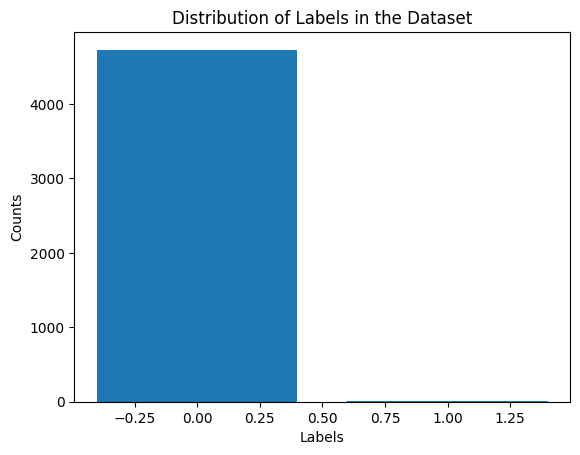

tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [ ]:


plot_label_distribution(train_data)




In [ ]:


train_loader = TemporalDataLoader(
    train_data,
    batch_size=args.bs,
    # neg_sampling_ratio=1.0,
)
val_loader = TemporalDataLoader(
    val_data,
    batch_size=args.bs,
    # neg_sampling_ratio=1.0,
)
test_loader = TemporalDataLoader(
    test_data,
    batch_size=args.bs,
    # neg_sampling_ratio=1.0,
)
neighbor_loader = LastNeighborLoader(data.num_nodes, size=10, device=device)




In [ ]:

class GraphAttentionEmbedding(torch.nn.Module):
    def __init__(self, in_channels, out_channels, msg_dim, time_enc):
        super().__init__()
        self.time_enc = time_enc
        edge_dim = msg_dim + time_enc.out_channels
        self.conv = TransformerConv(in_channels, out_channels // 2, heads=2,
                                    dropout=0.1, edge_dim=edge_dim)

    def forward(self, x, last_update, edge_index, t, msg):
        rel_t = last_update[edge_index[0]] - t
        rel_t_enc = self.time_enc(rel_t.to(x.dtype))
        edge_attr = torch.cat([rel_t_enc, msg], dim=-1)
        return self.conv(x, edge_index, edge_attr)

memory_dim = time_dim = embedding_dim = 20

memory = TGNMemory(
    data.num_nodes,
    data.msg.size(-1),
    memory_dim,
    time_dim,
    message_module=IdentityMessage(data.msg.size(-1), memory_dim, time_dim),
    aggregator_module=LastAggregator(),
).to(device)

gnn = GraphAttentionEmbedding(
    in_channels=memory_dim,
    out_channels=embedding_dim,
    msg_dim=data.msg.size(-1),
    time_enc=memory.time_enc,
).to(device)



AttributeError: 'GlobalStorage' object has no attribute 'msg'

## Implementation of the Classifier

In [ ]:

from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCNClassifier(torch.nn.Module):
    def __init__(self, node_features = 17, num_classes = 2):
        super().__init__()
        self.conv1 = GCNConv(node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output
    
class MLP(torch.nn.Module):
  def __init__(self, dim, drop=0.3):
    super().__init__()
    self.fc_1 = torch.nn.Linear(dim, 10)
    self.fc_3 = torch.nn.Linear(10, 1)
    self.act = torch.nn.ReLU()
    self.dropout = torch.nn.Dropout(p=drop, inplace=False)

  def forward(self, x):
    x = self.act(self.fc_1(x))
    x = self.dropout(x)
    return self.fc_3(x).squeeze(dim=1)


In [ ]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.lin_src = Linear(in_channels, in_channels)
        self.lin_dst = Linear(in_channels, in_channels)
        self.lin_final = Linear(in_channels, 1)

    def forward(self, z_src, z_dst):
        h = self.lin_src(z_src) + self.lin_dst(z_dst)
        h = h.relu()
        return self.lin_final(h)

In [ ]:
classifier = GCNClassifier(node_features=17, num_classes=2).to(device)

decoder = MLP(20).to(device)
# decoder_optimizer = torch.optim.Adam(set(memory.parameters()) | set(gnn.parameters()) | set(decoder.parameters()), lr=0.001)

# link_pred = LinkPredictor(in_channels=embedding_dim).to(device)
optimizer = torch.optim.Adam(set(memory.parameters()) | set(gnn.parameters()) | set(decoder.parameters()), lr=0.0001)

# criterion = torch.nn.BCELoss()
criterion = torch.nn.BCEWithLogitsLoss()


assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)


In [ ]:
def plot_embeddings(embeddings, epoch, folder_path, file_name):
    
    
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    tsne = TSNE(n_components=2)
    reduced_embeddings = tsne.fit_transform(embeddings.cpu().detach().numpy())


    plt.figure(figsize=(10,10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker='o', s=5)
    plt.title(f'Embeddings at Epoch {epoch}')
    
    plt.savefig(os.path.join(folder_path, file_name))
    plt.close()
    


def train():
    memory.train()
    gnn.train()
    decoder.train()
    # link_pred.train()

    memory.reset_state()  # Start with a fresh memory.
    neighbor_loader.reset_state()  # Start with an empty graph.

    total_loss = 0
    overall_batches = len(train_loader)
    
    print(f"Length of batches: {overall_batches}")
    
    for k, batch in enumerate(train_loader):
    # for batch in train_loader:
        optimizer.zero_grad()
        batch = batch.to(device)

        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))
        
        hidden_state = z[assoc[batch.src]]

        out = decoder(hidden_state)
        pred = out.sigmoid()
        
        loss = criterion(pred, batch.y)

        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)

        loss.backward()
        optimizer.step()
        memory.detach()
        
        total_loss += float(loss) * batch.num_events
        
        if k % 100 == 0:
            print(f"Trainings batch loaded: {k} / {overall_batches}""")

    return total_loss / train_data.num_events


@torch.no_grad()
def test(loader):
    memory.eval()
    gnn.eval()
    # link_pred.eval()
    decoder.eval()


    total_loss = 0
    torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.
    
    overall_batches = len(loader)
    aps, aucs = [], []
    
    for k, batch in enumerate(loader):
    
        batch = batch.to(device)
        n_id, edge_index, e_id = neighbor_loader(batch.n_id)
        assoc[n_id] = torch.arange(n_id.size(0), device=device)

        z, last_update = memory(n_id)
        z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
                data.msg[e_id].to(device))

        out = decoder(z[assoc[batch.src]])        
        # out = classifier(z[assoc[batch.src]])
        
        pred = out.sigmoid()
        loss = criterion(pred, batch.y)
        
        aps.append(average_precision_score(batch.y, pred))
        
        if len(np.unique(batch.y.cpu().numpy())) > 1:
            aucs.append(roc_auc_score(batch.y, pred))
        else:
            print("Skipped ROC AUC computation for this batch as it contains only one class.")


        memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
        neighbor_loader.insert(batch.src, batch.dst)
        
        total_loss += float(loss) * batch.num_events
        if k % 100 == 0:
            print(f"Test batch loaded: {k} / {overall_batches}""")
        
    return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean()), total_loss 

train_losses = []
validation_losses = []

def get_node_embedding_output_folder_path():
    
    if BUILD_DEVICE == 'local':
        folder_path = '/app/graph_playground/data/output/node_embeddings'
    elif BUILD_DEVICE == 'server':
        folder_path = '/export/home/s2995839/iot-unsw-2/output/node_embeddings'
        
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    return folder_path

def get_loss_output_path():
    
    if BUILD_DEVICE == 'local':
        folder_path = '/app/graph_playground/data/output/trainings_process'
    elif BUILD_DEVICE == 'server':
        folder_path = '/export/home/s2995839/iot-unsw-2/output/trainings_process'
        
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    return folder_path




for epoch in range(1, 21):
    train_loss = train()
    train_losses.append(train_loss)
    
    with torch.no_grad():
        n_id = torch.arange(memory.num_nodes, device=device)  # assuming memory has num_nodes attribute to get all nodes
        embeddings, _ = memory(n_id)
        output_path_node_embedding = get_node_embedding_output_folder_path()
        plot_embeddings(embeddings, epoch, folder_path=output_path_node_embedding, file_name=f'Node_Embedding_Epoch_{epoch}.png')
    
    print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}')
    
    val_ap, val_auc, val_loss = test(val_loader)
    validation_losses.append(val_loss)    
    test_ap, test_auc, test_loss = test(test_loader)
    
    print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
    print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')
    
    if early_stopper.early_stop(val_loss):         
        print(f"Early stopping: {epoch} epochs")    
        break
    
    
def plot_trainings_loss(output_trainings_loss_path):

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Save the plot in the specified folder
    plt.savefig(os.path.join(output_trainings_loss_path, 'loss_evolution.png'))
    plt.close()

output_trainings_loss = get_loss_output_path()
plot_trainings_loss(output_trainings_loss)


def get_model_output_path():
    
    if BUILD_DEVICE == 'local':
        folder_path = '/app/graph_playground/data/output/tgn-model'
    elif BUILD_DEVICE == 'server':
        folder_path = '/export/home/s2995839/iot-unsw-2/output/tgn-model'

    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    return folder_path


model_output_path = get_model_output_path()
model_file_path = os.path.join(model_output_path, "your_model_name.pt")
torch.save(gnn.state_dict(), model_file_path)


# Load 
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load(PATH))
# model.eval()

Length of batches: 706
Trainings batch loaded: 0 / 706
Trainings batch loaded: 100 / 706
Trainings batch loaded: 200 / 706
Trainings batch loaded: 300 / 706
Trainings batch loaded: 400 / 706
Trainings batch loaded: 500 / 706
Trainings batch loaded: 600 / 706
Trainings batch loaded: 700 / 706
Epoch: 01, Loss: 0.8031
Test batch loaded: 0 / 152
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found i

Skipped ROC AUC computation for this batch as it contains only one class.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Skipped ROC AUC computation for this batch as it contains only one class.
Test batch loaded: 100 / 152


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found i

Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Test batch loaded: 0 / 151
Skipped ROC AUC computation for this batch as it contains only one class.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Skipped ROC AUC computation for this batch as it contains only one class.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.
Test batch loaded: 100 / 151
Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Skipped ROC AUC computation for this batch as it contains only one class.
Skipped ROC AUC computation for this batch as it contains only one class.


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Skipped ROC AUC computation for this batch as it contains only one class.
Val AP: 0.1047, Val AUC: 0.4742
Test AP: 0.1781, Test AUC: 0.5332
Length of batches: 706
Trainings batch loaded: 0 / 706
Trainings batch loaded: 100 / 706
Trainings batch loaded: 200 / 706
Trainings batch loaded: 300 / 706
Trainings batch loaded: 400 / 706
Trainings batch loaded: 500 / 706
Trainings batch loaded: 600 / 706


KeyboardInterrupt: 

## Old Code for Node Classification

In [ ]:
# def plot_embeddings(embeddings, labels, epoch):
#     tsne = TSNE(n_components=2)
#     reduced_embeddings = tsne.fit_transform(embeddings.cpu().detach().numpy())

#     colors = ['red' if label == 1 else 'blue' for label in labels]

#     plt.figure(figsize=(10,10))
#     plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, marker='o', s=5)
#     plt.title(f'Embeddings at Epoch {epoch}')
#     plt.show()
    
    
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
# plt.plot(validation_losses, label='Validation Loss')
# plt.title('Loss Evolution')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.show()
    


# def train():
#     memory.train()
#     gnn.train()
#     # classifier.train()
#     decoder.train()

#     memory.reset_state()  # Start with a fresh memory.
#     neighbor_loader.reset_state()  # Start with an empty graph.

#     total_loss = 0
#     overall_batches = len(train_loader)
    
#     print(f"Length of batches: {overall_batches}")
    
#     for k, batch in enumerate(train_loader):
#     # for batch in train_loader:
#         decoder_optimizer.zero_grad()
#         batch = batch.to(device)

#         n_id = torch.cat([batch.src, batch.dst]).unique()
#         n_id, edge_index, e_id = neighbor_loader(n_id)
        
#         assoc[n_id] = torch.arange(n_id.size(0), device=device)

#         z, last_update = memory(n_id)
#         z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
#                 data.msg[e_id].to(device))

#         hidden_state = z[assoc[batch.src]]

        
        
#         # plot_embeddings(hidden_state, k)
        
#         out = decoder(hidden_state)
#         pred = out.sigmoid()
        
        
        
#         loss = criterion(pred, batch.y)

#         memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
#         neighbor_loader.insert(batch.src, batch.dst)

#         loss.backward()
#         decoder_optimizer.step()
#         memory.detach()
        
#         total_loss += float(loss) * batch.num_events
#         if k % 100 == 0:
#             print(f"Trainings batch loaded: {k} / {overall_batches}""")

#     return total_loss / train_data.num_events


# @torch.no_grad()
# def test(loader):
#     memory.eval()
#     gnn.eval()
#     classifier.eval()

#     total_loss = 0
#     correct = 0
#     torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.
#     overall_batches = len(loader)

#     aps, aucs = [], []
    
#     for k, batch in enumerate(loader):
    
#         batch = batch.to(device)
        
#         batch_size = BATCH_SIZE
#         num_instance = len(data.src)
        
#         s_idx = k * batch_size
#         e_idx = min(num_instance, s_idx + batch_size)

#         n_id = torch.cat([batch.src, batch.dst]).unique()
#         n_id, edge_index, e_id = neighbor_loader(n_id)

#         assoc[n_id] = torch.arange(n_id.size(0), device=device)

#         z, last_update = memory(n_id)
#         z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
#                 data.msg[e_id].to(device))
        
#         # plot_embeddings(z, k)
#         # plot_embeddings(z, batch.y.cpu().numpy(), k)

#         plot_embeddings(z[assoc[batch.src]], batch.y.cpu().numpy(), k)

        
#         out = decoder(z[assoc[batch.src]])
#         # out = classifier(z[assoc[batch.src]])
#         pred = out.sigmoid()
    
#         memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
#         neighbor_loader.insert(batch.src, batch.dst)
        
#         true_labels_loss = batch.y
#         predicted_scores_loss = pred
#         true_labels = batch.y.cpu().numpy()
#         predicted_scores = pred.cpu().numpy()
        
#         loss = criterion(predicted_scores_loss, true_labels_loss)
    
    
#         ap = average_precision_score(true_labels, predicted_scores)
#         # auc = roc_auc_score(true_labels, predicted_scores)
    
#         aps.append(ap)
#         # aucs.append(auc)
        
#         total_loss += float(loss) * batch.num_events
#         if k % 100 == 0:
#             print(f"Test batch loaded: {k} / {overall_batches}""")
        
        
        
#     return float(torch.tensor(aps).mean()), total_loss 

# train_losses = []
# validation_losses = []

# for epoch in range(1, 51):
#     train_loss = train()
#     train_losses.append(train_loss)
    
#     # with torch.no_grad():
#     #     n_id = torch.arange(memory.num_nodes, device=device)  # assuming memory has num_nodes attribute to get all nodes
#     #     embeddings, _ = memory(n_id)
#     #     plot_embeddings(embeddings, epoch)
    
#     print(f'Epoch: {epoch:02d}, Loss: {train_loss:.4f}')
#     val_ap, val_loss = test(val_loader)
#     validation_losses.append(val_loss)    
#     test_ap, _ = test(test_loader)
    
#     if early_stopper.early_stop(val_loss):         
#         print(f"Early stopping: {epoch} epochs")    
#         break
    
#     print(f'Val AP: {val_ap:.4f}')
#     print(f'Test AP: {test_ap:.4f}')
    
#     # val_ap, val_auc = test(val_loader)
#     # test_ap, test_auc = test(test_loader)
#     # print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
#     # print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')

In [ ]:


# link_pred = LinkPredictor(in_channels=embedding_dim).to(device)

# optimizer = torch.optim.Adam(
#     set(memory.parameters()) | set(gnn.parameters())
#     | set(link_pred.parameters()), lr=0.0001)
# criterion = torch.nn.BCEWithLogitsLoss()

# # Helper vector to map global node indices to local ones.
# assoc = torch.empty(data.num_nodes, dtype=torch.long, device=device)


# def train():
#     memory.train()
#     gnn.train()
#     link_pred.train()

#     memory.reset_state()  # Start with a fresh memory.
#     neighbor_loader.reset_state()  # Start with an empty graph.

#     total_loss = 0
#     for batch in train_loader:
#         optimizer.zero_grad()
#         batch = batch.to(device)

#         n_id, edge_index, e_id = neighbor_loader(batch.n_id)
#         assoc[n_id] = torch.arange(n_id.size(0), device=device)

#         # Get updated memory of all nodes involved in the computation.
#         z, last_update = memory(n_id)
#         z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
#                 data.msg[e_id].to(device))
#         pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
#         neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

#         loss = criterion(pos_out, torch.ones_like(pos_out))
#         loss += criterion(neg_out, torch.zeros_like(neg_out))

#         # Update memory and neighbor loader with ground-truth state.
#         memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
#         neighbor_loader.insert(batch.src, batch.dst)

#         loss.backward()
#         optimizer.step()
#         memory.detach()
#         total_loss += float(loss) * batch.num_events

#     return total_loss / train_data.num_events


# @torch.no_grad()
# def test(loader):
#     memory.eval()
#     gnn.eval()
#     link_pred.eval()

#     torch.manual_seed(12345)  # Ensure deterministic sampling across epochs.

#     aps, aucs = [], []
#     for batch in loader:
#         batch = batch.to(device)

#         n_id, edge_index, e_id = neighbor_loader(batch.n_id)
#         assoc[n_id] = torch.arange(n_id.size(0), device=device)

#         z, last_update = memory(n_id)
#         z = gnn(z, last_update, edge_index, data.t[e_id].to(device),
#                 data.msg[e_id].to(device))
#         pos_out = link_pred(z[assoc[batch.src]], z[assoc[batch.dst]])
#         neg_out = link_pred(z[assoc[batch.src]], z[assoc[batch.neg_dst]])

#         y_pred = torch.cat([pos_out, neg_out], dim=0).sigmoid().cpu()
#         y_true = torch.cat(
#             [torch.ones(pos_out.size(0)),
#              torch.zeros(neg_out.size(0))], dim=0)

#         aps.append(average_precision_score(y_true, y_pred))
#         aucs.append(roc_auc_score(y_true, y_pred))

#         memory.update_state(batch.src, batch.dst, batch.t, batch.msg)
#         neighbor_loader.insert(batch.src, batch.dst)
#     return float(torch.tensor(aps).mean()), float(torch.tensor(aucs).mean())


# for epoch in range(1, 51):
#     loss = train()
#     print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')
#     val_ap, val_auc = test(val_loader)
#     test_ap, test_auc = test(test_loader)
#     print(f'Val AP: {val_ap:.4f}, Val AUC: {val_auc:.4f}')
#     print(f'Test AP: {test_ap:.4f}, Test AUC: {test_auc:.4f}')